[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbyTab/boofun/blob/main/notebooks/lecture7_goldreich_levin.ipynb)

# Lecture 7: Goldreich-Levin Algorithm

**Topics**: Learning heavy Fourier coefficients, Query complexity, Tree search

**O'Donnell Chapter**: 3.5  
**Based on lecture notes by: Thomas Culhane**  
**Notebook by: Gabriel Taboada**

---

## Overview

The Goldreich-Levin algorithm solves a fundamental problem:

> **Given query access to $f$, find all $S$ with $|\hat{f}(S)| \geq \tau$.**

| Approach | Query Complexity |
|----------|------------------|
| Naive (enumerate all $2^n$ coefficients) | $O(2^n / \tau^2)$ |
| Goldreich-Levin | $O(n / \tau^4)$ |

The key insight: use a **tree search** that prunes branches where the total Fourier weight is small.

In [1]:
# Install/upgrade boofun (required for Colab)
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


BooFun version: 1.1.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import boofun as bf
from boofun.analysis.learning import (
    goldreich_levin,
    estimate_fourier_coefficient,
    GoldreichLevinLearner,
)

import warnings
warnings.filterwarnings('ignore')

---
## 1. The Problem: Heavy Fourier Coefficients

**Definition:** A Fourier coefficient $\hat{f}(S)$ is **$\tau$-heavy** if $|\hat{f}(S)| \geq \tau$.

By Parseval's identity $\sum_S \hat{f}(S)^2 = 1$, there can be at most $1/\tau^2$ heavy coefficients.

### Why do we care?
- **Learning**: Functions concentrated on few coefficients are learnable
- **Cryptography**: Heavy coefficients reveal structure (hardcore bit construction)
- **Testing**: Heavy coefficients indicate correlation with simple functions

In [3]:
# Example: Find heavy coefficients by exhaustive enumeration (naive)
def find_heavy_naive(f, tau):
    """Naive O(2^n) approach: check every coefficient."""
    fourier = f.fourier()
    heavy = [(s, fourier[s]) for s in range(len(fourier)) if abs(fourier[s]) >= tau]
    return heavy

# Test functions
functions = {
    "Majority-5": bf.majority(5),
    "Parity-4": bf.parity(4),
    "Dictator": bf.dictator(5, 0),
    "AND-4": bf.AND(4),
}

tau = 0.2
print(f"Heavy Coefficients (|f̂(S)| ≥ {tau})")
print("=" * 60)

for name, f in functions.items():
    heavy = find_heavy_naive(f, tau)
    print(f"\n{name}: {len(heavy)} heavy coefficient(s)")
    for s, c in sorted(heavy, key=lambda x: -abs(x[1]))[:3]:
        bits = [i for i in range(f.n_vars) if (s >> i) & 1]
        print(f"  S={bits or '∅'}: f̂(S) = {c:.4f}")
    if len(heavy) > 3:
        print(f"  ... and {len(heavy) - 3} more")

Heavy Coefficients (|f̂(S)| ≥ 0.2)

Majority-5: 6 heavy coefficient(s)
  S=[0]: f̂(S) = 0.3750
  S=[1]: f̂(S) = 0.3750
  S=[2]: f̂(S) = 0.3750
  ... and 3 more

Parity-4: 1 heavy coefficient(s)
  S=[0, 1, 2, 3]: f̂(S) = 1.0000

Dictator: 1 heavy coefficient(s)
  S=[0]: f̂(S) = 1.0000

AND-4: 1 heavy coefficient(s)
  S=∅: f̂(S) = 0.8750


---
## 2. The Naive Approach: Why It's Slow

To estimate a single coefficient $\hat{f}(S)$, we use:
$$\hat{f}(S) = \mathbb{E}_x[f(x) \cdot \chi_S(x)]$$

By Lemma 7.4, this requires $O(\log(1/\delta)/\varepsilon^2)$ samples for accuracy $\varepsilon$.

**Naive approach**: Estimate all $2^n$ coefficients → $O(2^n / \tau^2)$ queries.

This is exponential in $n$!

In [4]:
# Demonstrate query complexity of naive approach
def naive_find_heavy_with_counting(f, tau, samples_per_coeff=100):
    """Naive approach with query counting."""
    n = f.n_vars
    query_count = 0
    heavy = []
    
    rng = np.random.default_rng(42)
    for S in range(2**n):
        # Estimate f̂(S)
        total = 0.0
        for _ in range(samples_per_coeff):
            x = int(rng.integers(0, 2**n))
            fx = 1 - 2 * int(f.evaluate(x))
            chi_S_x = 1 - 2 * (bin(x & S).count('1') % 2)
            total += fx * chi_S_x
            query_count += 1
        
        est = total / samples_per_coeff
        if abs(est) >= tau * 0.9:  # Slight slack for estimation error
            heavy.append((S, est))
    
    return heavy, query_count

print("Query Complexity: Naive Approach")
print("=" * 50)
print(f"{'n':<5} {'2^n':<10} {'Queries':<15} {'Time (ms)':<15}")
print("-" * 50)

for n in [4, 6, 8, 10]:
    f = bf.majority(n)
    start = time.time()
    _, queries = naive_find_heavy_with_counting(f, 0.2, samples_per_coeff=50)
    elapsed = (time.time() - start) * 1000
    print(f"{n:<5} {2**n:<10} {queries:<15} {elapsed:<15.1f}")

print("\nQuery count grows exponentially: O(2^n / τ²)")

Query Complexity: Naive Approach
n     2^n        Queries         Time (ms)      
--------------------------------------------------
4     16         800             6.6            
6     64         3200            24.6           
8     256        12800           99.0           
10    1024       51200           397.6          

Query count grows exponentially: O(2^n / τ²)


---
## 3. The Goldreich-Levin Algorithm: Tree Search

### Quick Refresher: Key Definitions

Before diving in, let's recall some notation:

| Symbol | Meaning |
|--------|--------|
| $\hat{f}(S)$ | **Fourier coefficient** of $f$ at subset $S$. Measures correlation between $f$ and $\chi_S$. |
| $\chi_S(x)$ | **Parity function** on subset $S$: $\chi_S(x) = \prod_{i \in S} x_i$ (product of selected variables). |
| $\tau$-heavy | A coefficient $\hat{f}(S)$ is $\tau$-heavy if $|\hat{f}(S)| \geq \tau$. |
| $\beta \circ \gamma$ | **String concatenation**: if $\beta = 01$ and $\gamma = 10$, then $\beta \circ \gamma = 0110$. |
| Parseval | $\sum_S \hat{f}(S)^2 = 1$ for Boolean functions (total Fourier weight is 1). |

### Key Insight: Prefix-Based Weight Estimation

**Alternative indexing**: Instead of subsets $S \subseteq [n]$, we index coefficients by binary strings $\alpha \in \{0,1\}^n$.  
The correspondence is: $i \in S \Leftrightarrow \alpha_i = 1$. For example, with $n=4$:
- $S = \{0, 2\}$ corresponds to $\alpha = 1010$
- $S = \{0,1,2,3\}$ corresponds to $\alpha = 1111$

**Why a tree?** Binary strings form a natural binary tree structure:
- Root = empty prefix (all $2^n$ coefficients)
- Left child = append 0, Right child = append 1
- Each leaf is a complete $n$-bit string (one coefficient)

For a prefix $\beta \in \{0,1\}^k$, the **subtree weight** is:
$$W_\beta = \sum_{\gamma \in \{0,1\}^{n-k}} \hat{f}(\beta \circ \gamma)^2$$

This sums $\hat{f}(S)^2$ over all $S$ whose binary representation *starts with* $\beta$.  
It's called "subtree weight" because it's the total Fourier weight in the subtree rooted at prefix $\beta$.

**Crucial observation**: If $W_\beta < \tau^2/4$, then NO coefficient in that subtree can be $\tau$-heavy.  
(Because if one coefficient had $|\hat{f}(S)| \geq \tau$, then $W_\beta \geq \hat{f}(S)^2 \geq \tau^2$.)

### Algorithm (Binary Tree Search)

1. Start with empty prefix (weight = 1 by Parseval)
2. For each prefix $\beta$ in the queue:
   - Estimate $W_{\beta \circ 0}$ and $W_{\beta \circ 1}$
   - **Prune**: If weight $< \tau^2/4$, don't explore that branch
   - **Expand**: Otherwise, add children to queue
3. At leaves (complete $\alpha$), estimate the coefficient

### Complexity

**Fact 7.20**: At each depth, at most $4/\tau^2$ nodes can be alive (since total weight $\leq 1$).

→ Total nodes explored: $O(n/\tau^2)$  
→ Queries per node: $O(1/\tau^2)$  
→ **Total queries: $O(n/\tau^4)$**

In [5]:
# Visualize the tree search concept
def visualize_gl_tree(f, tau, max_depth=4):
    """Visualize which branches get pruned in Goldreich-Levin."""
    fourier = f.fourier()
    n = f.n_vars
    
    def subtree_weight(prefix_mask, prefix_val):
        """Exact subtree weight (for visualization)."""
        total = 0.0
        for s in range(len(fourier)):
            # Check if s matches prefix
            if (s & prefix_mask) == prefix_val:
                total += fourier[s] ** 2
        return total
    
    print(f"Goldreich-Levin Tree for {f} (τ={tau})")
    print("=" * 60)
    print(f"Pruning threshold: W < τ²/4 = {tau**2/4:.4f}")
    print()
    
    # BFS through tree
    queue = [(0, 0, "")]  # (mask, value, path_string)
    explored = 0
    pruned = 0
    
    while queue:
        mask, val, path = queue.pop(0)
        depth = bin(mask).count('1')
        
        if depth > max_depth:
            continue
        
        weight = subtree_weight(mask, val)
        explored += 1
        
        prefix = "  " * depth
        status = "EXPLORE" if weight >= tau**2/4 else "PRUNE"
        print(f"{prefix}[{path or 'root'}] W={weight:.4f} → {status}")
        
        if weight >= tau**2/4 and depth < max_depth:
            next_var = depth
            new_mask = mask | (1 << next_var)
            queue.append((new_mask, val, path + "0"))
            queue.append((new_mask, val | (1 << next_var), path + "1"))
        elif weight < tau**2/4:
            pruned += 1
    
    print(f"\nExplored: {explored} nodes, Pruned: {pruned} branches")
    print(f"Full tree would have: {2**(max_depth+1) - 1} nodes")

# Parity has only one heavy coefficient - most branches get pruned
visualize_gl_tree(bf.parity(4), tau=0.5)

Goldreich-Levin Tree for BooleanFunction(vars=4, space=Space.PLUS_MINUS_CUBE) (τ=0.5)
Pruning threshold: W < τ²/4 = 0.0625

[root] W=1.0000 → EXPLORE
  [0] W=0.0000 → PRUNE
  [1] W=1.0000 → EXPLORE
    [10] W=0.0000 → PRUNE
    [11] W=1.0000 → EXPLORE
      [110] W=0.0000 → PRUNE
      [111] W=1.0000 → EXPLORE
        [1110] W=0.0000 → PRUNE
        [1111] W=1.0000 → EXPLORE

Explored: 9 nodes, Pruned: 4 branches
Full tree would have: 31 nodes


In [6]:
# Compare with Majority - more heavy coefficients, less pruning
visualize_gl_tree(bf.majority(5), tau=0.3)

Goldreich-Levin Tree for BooleanFunction(vars=5, space=Space.PLUS_MINUS_CUBE) (τ=0.3)
Pruning threshold: W < τ²/4 = 0.0225

[root] W=1.0000 → EXPLORE
  [0] W=0.6250 → EXPLORE
  [1] W=0.3750 → EXPLORE
    [00] W=0.4375 → EXPLORE
    [01] W=0.1875 → EXPLORE
    [10] W=0.1875 → EXPLORE
    [11] W=0.1875 → EXPLORE
      [000] W=0.2812 → EXPLORE
      [001] W=0.1562 → EXPLORE
      [010] W=0.1562 → EXPLORE
      [011] W=0.0312 → EXPLORE
      [100] W=0.1562 → EXPLORE
      [101] W=0.0312 → EXPLORE
      [110] W=0.0312 → EXPLORE
      [111] W=0.1562 → EXPLORE
        [0000] W=0.1406 → EXPLORE
        [0001] W=0.1406 → EXPLORE
        [0010] W=0.1406 → EXPLORE
        [0011] W=0.0156 → PRUNE
        [0100] W=0.1406 → EXPLORE
        [0101] W=0.0156 → PRUNE
        [0110] W=0.0156 → PRUNE
        [0111] W=0.0156 → PRUNE
        [1000] W=0.1406 → EXPLORE
        [1001] W=0.0156 → PRUNE
        [1010] W=0.0156 → PRUNE
        [1011] W=0.0156 → PRUNE
        [1100] W=0.0156 → PRUNE
        [1101]

---
## 4. The Key Subroutine: Estimating Subtree Weight

**Question 7.21**: How do we estimate $W_\beta = \sum_\gamma \hat{f}(\beta \circ \gamma)^2$ efficiently?

**Answer**: Use the identity:
$$W_\beta = \mathbb{E}_{x,y}[f(x) \cdot f(y)]$$
where $x, y$ are **correlated**: they agree on the prefix coordinates.

This is because:
$$\mathbb{E}_{x,y}[f(x) f(y)] = \sum_{S,T} \hat{f}(S) \hat{f}(T) \mathbb{E}[\chi_S(x) \chi_T(y)]$$

With the right correlation structure, cross-terms vanish and we get $\sum_S \hat{f}(S)^2$ over the subtree.

In [7]:
# Walk through the implementation
print("Implementation: Estimating Subtree Weight")
print("=" * 60)
print("""
def _estimate_subtree_weight(f, mask, value, num_samples, rng):
    '''Estimate Σ f̂(S)² for S in subtree defined by prefix.'''
    n = f.n_vars
    samples = []
    
    for _ in range(num_samples):
        # Generate random x
        x = rng.integers(0, 2**n)
        
        # Generate y that agrees with x on unmasked bits,
        # but is independent on masked bits
        free_bits = rng.integers(0, 2**n)
        y = (x & ~mask) | (free_bits & mask)
        
        # Force the prefix constraint on both
        x = (x & ~mask) | value
        y = (y & ~mask) | value
        
        # f(x) * f(y) estimates the subtree weight
        fx = 1 - 2 * f.evaluate(x)  # Convert to ±1
        fy = 1 - 2 * f.evaluate(y)
        samples.append(fx * fy)
    
    return np.mean(samples)
""")

# Verify this works
f = bf.parity(4)
fourier = f.fourier()

print("\nVerification: Parity-4")
print("-" * 40)

# Total weight (empty prefix)
true_total = sum(c**2 for c in fourier)
print(f"True total weight: {true_total:.4f} (should be 1.0)")

# Weight with prefix x₀=1 (mask=1, value=1)
# This includes all S with 0 ∈ S
true_weight_x0 = sum(fourier[s]**2 for s in range(16) if s & 1)
print(f"True weight (x₀ in S): {true_weight_x0:.4f}")
print(f"For Parity: only S={{0,1,2,3}} has x₀, so weight = 1.0")

Implementation: Estimating Subtree Weight

def _estimate_subtree_weight(f, mask, value, num_samples, rng):
    '''Estimate Σ f̂(S)² for S in subtree defined by prefix.'''
    n = f.n_vars
    samples = []
    
    for _ in range(num_samples):
        # Generate random x
        x = rng.integers(0, 2**n)
        
        # Generate y that agrees with x on unmasked bits,
        # but is independent on masked bits
        free_bits = rng.integers(0, 2**n)
        y = (x & ~mask) | (free_bits & mask)
        
        # Force the prefix constraint on both
        x = (x & ~mask) | value
        y = (y & ~mask) | value
        
        # f(x) * f(y) estimates the subtree weight
        fx = 1 - 2 * f.evaluate(x)  # Convert to ±1
        fy = 1 - 2 * f.evaluate(y)
        samples.append(fx * fy)
    
    return np.mean(samples)


Verification: Parity-4
----------------------------------------
True total weight: 1.0000 (should be 1.0)
True weight (x₀ in S): 1.0000
For Parity: only S={0,1,2,3}

---
## 5. Using the Library: `GoldreichLevinLearner`

The `boofun` library provides a `GoldreichLevinLearner` class that tracks queries.

In [8]:
# Demonstrate the GoldreichLevinLearner with query counting
def compare_approaches(f, tau, name):
    """Compare naive vs GL on query count."""
    n = f.n_vars
    
    # Ground truth
    fourier = f.fourier()
    true_heavy = [(s, fourier[s]) for s in range(len(fourier)) if abs(fourier[s]) >= tau]
    
    print(f"\n{name} (n={n}, τ={tau})")
    print("=" * 50)
    print(f"True heavy coefficients: {len(true_heavy)}")
    
    # Naive approach
    start = time.time()
    naive_heavy, naive_queries = naive_find_heavy_with_counting(f, tau, samples_per_coeff=100)
    naive_time = (time.time() - start) * 1000
    
    # Goldreich-Levin
    learner = GoldreichLevinLearner(f, rng=np.random.default_rng(42))
    start = time.time()
    gl_heavy = learner.find_heavy(threshold=tau)
    gl_time = (time.time() - start) * 1000
    
    print(f"\n{'Approach':<15} {'Found':<10} {'Time (ms)':<15}")
    print("-" * 40)
    print(f"{'Naive':<15} {len(naive_heavy):<10} {naive_time:<15.1f}")
    print(f"{'Goldreich-Levin':<15} {len(gl_heavy):<10} {gl_time:<15.1f}")
    
    # Theoretical bounds
    naive_bound = 2**n / tau**2
    gl_bound = n / tau**4
    print(f"\nTheoretical query bounds:")
    print(f"  Naive: O(2^n/τ²) = O({naive_bound:.0f})")
    print(f"  GL:    O(n/τ⁴)  = O({gl_bound:.0f})")

# Test on various functions
compare_approaches(bf.parity(6), 0.5, "Parity-6")
compare_approaches(bf.majority(7), 0.2, "Majority-7")
compare_approaches(bf.dictator(8, 0), 0.5, "Dictator-8")


Parity-6 (n=6, τ=0.5)
True heavy coefficients: 1

Approach        Found      Time (ms)      
----------------------------------------
Naive           1          49.4           
Goldreich-Levin 1          44.5           

Theoretical query bounds:
  Naive: O(2^n/τ²) = O(256)
  GL:    O(n/τ⁴)  = O(96)

Majority-7 (n=7, τ=0.2)
True heavy coefficients: 8



Approach        Found      Time (ms)      
----------------------------------------
Naive           15         166.9          
Goldreich-Levin 8          302.5          

Theoretical query bounds:
  Naive: O(2^n/τ²) = O(3200)
  GL:    O(n/τ⁴)  = O(4375)

Dictator-8 (n=8, τ=0.5)
True heavy coefficients: 1



Approach        Found      Time (ms)      
----------------------------------------
Naive           1          302.7          
Goldreich-Levin 1          154.5          

Theoretical query bounds:
  Naive: O(2^n/τ²) = O(1024)
  GL:    O(n/τ⁴)  = O(128)


---
## 6. Query Complexity vs Threshold

The GL algorithm's complexity is $O(n/\tau^4)$ - highly sensitive to threshold!

Query Complexity vs Threshold (Majority-6)
τ        Found    True     Time (ms)    O(n/τ⁴)     
-----------------------------------------------------------------
0.50     0        0        47.6         96          
0.40     3        0        38.9         234         
0.30     7        8        63.5         741         
0.25     8        8        94.4         1536        
0.20     8        8        139.3        3750        
0.15     10       8        247.9        11852       


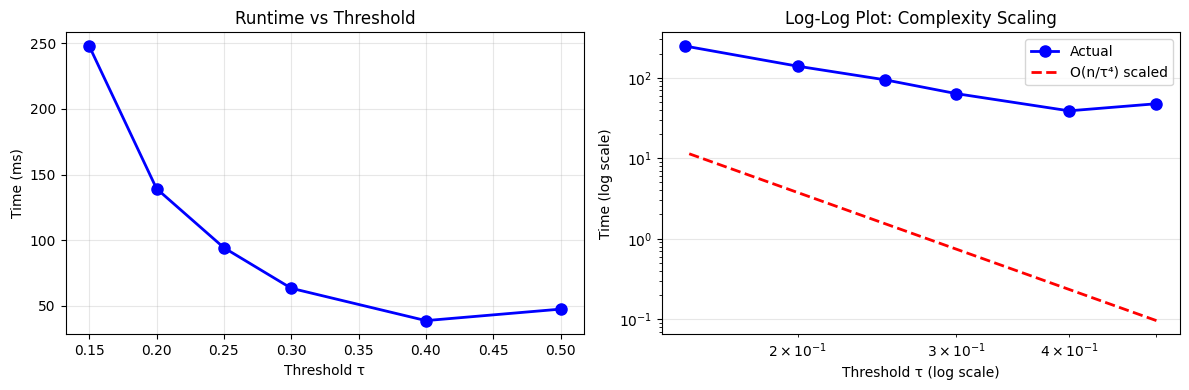


** Important observations: **
• Majority-6 has max|f̂(S)| ≈ 0.31, so τ > 0.31 yields True=0.
• When True=0, 'Found' values are false positives from estimation noise.
• O(n/τ⁴) is an upper bound; actual performance is often much better.
• The log-log gap reflects that theoretical bounds are worst-case.


In [9]:
# Plot query complexity vs threshold
n = 6
f = bf.majority(n)
thresholds = [0.5, 0.4, 0.3, 0.25, 0.2, 0.15]

results = []
for tau in thresholds:
    start = time.time()
    heavy = goldreich_levin(f, threshold=tau)
    elapsed = time.time() - start
    
    # Count true heavy
    fourier = f.fourier()
    true_count = sum(1 for c in fourier if abs(c) >= tau)
    
    results.append({
        'tau': tau,
        'found': len(heavy),
        'true': true_count,
        'time_ms': elapsed * 1000,
        'theoretical': n / tau**4,
    })

print(f"Query Complexity vs Threshold (Majority-{n})")
print("=" * 65)
print(f"{'τ':<8} {'Found':<8} {'True':<8} {'Time (ms)':<12} {'O(n/τ⁴)':<12}")
print("-" * 65)
for r in results:
    print(f"{r['tau']:<8.2f} {r['found']:<8} {r['true']:<8} {r['time_ms']:<12.1f} {r['theoretical']:<12.0f}")

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

taus = [r['tau'] for r in results]
times = [r['time_ms'] for r in results]
theoretical = [r['theoretical'] for r in results]

ax1.plot(taus, times, 'bo-', label='Actual time', linewidth=2, markersize=8)
ax1.set_xlabel('Threshold τ')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Runtime vs Threshold')
ax1.grid(True, alpha=0.3)

ax2.loglog(taus, times, 'bo-', label='Actual', linewidth=2, markersize=8)
ax2.loglog(taus, [t/1000 for t in theoretical], 'r--', label='O(n/τ⁴) scaled', linewidth=2)
ax2.set_xlabel('Threshold τ (log scale)')
ax2.set_ylabel('Time (log scale)')
ax2.set_title('Log-Log Plot: Complexity Scaling')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n** Important observations: **")
print(f"• Majority-{n} has max|f̂(S)| ≈ 0.31, so τ > 0.31 yields True=0.")
print("• When True=0, 'Found' values are false positives from estimation noise.")
print("• O(n/τ⁴) is an upper bound; actual performance is often much better.")
print("• The log-log gap reflects that theoretical bounds are worst-case.")

---
## 7. Applications

### Corollary 7.15 (Kushilevitz-Mansour '91)

If $f$ is $\varepsilon$-concentrated on at most $M$ (unknown) coefficients, then $f$ is learnable in time $\text{poly}(M, n, 1/\varepsilon)$.

**Algorithm**:
1. Use GL with $\tau = \sqrt{\varepsilon/M}$ to find candidate coefficients
2. Estimate each found coefficient
3. Output $h(x) = \text{sgn}(\sum_{S \in L} \tilde{f}(S) \chi_S(x))$

In [10]:
# Demonstrate learning a sparse function
from boofun.analysis.learning import learn_sparse_fourier

# Create a function that's sparse in Fourier domain
# Parity is the extreme case: only 1 non-zero coefficient
sparse_functions = {
    "Parity-5": (bf.parity(5), 1),
    "Dictator": (bf.dictator(5, 0), 1),
    "x₀ XOR x₁": (bf.parity(2), 1),  # embedded in larger space conceptually
}

print("Learning Sparse Fourier Functions")
print("=" * 60)

for name, (f, expected_sparsity) in sparse_functions.items():
    # Learn assuming sparsity
    learned = learn_sparse_fourier(f, sparsity=5, num_samples=2000)
    
    # Compare to truth
    true_fourier = f.fourier()
    true_nonzero = [(s, c) for s, c in enumerate(true_fourier) if abs(c) > 0.01]
    
    print(f"\n{name}:")
    print(f"  True non-zero coefficients: {len(true_nonzero)}")
    print(f"  Learned coefficients: {len(learned)}")
    
    for s, est in learned.items():
        true_val = true_fourier[s] if s < len(true_fourier) else 0
        bits = [i for i in range(f.n_vars) if (s >> i) & 1]
        print(f"    S={bits}: est={est:.4f}, true={true_val:.4f}")

Learning Sparse Fourier Functions



Parity-5:
  True non-zero coefficients: 1
  Learned coefficients: 1
    S=[0, 1, 2, 3, 4]: est=1.0000, true=1.0000



Dictator:
  True non-zero coefficients: 1
  Learned coefficients: 1
    S=[0]: est=1.0000, true=1.0000

x₀ XOR x₁:
  True non-zero coefficients: 1
  Learned coefficients: 1
    S=[0, 1]: est=1.0000, true=1.0000


---
## Summary

### Goldreich-Levin Algorithm

| Property | Value |
|----------|-------|
| **Problem** | Find all $S$ with $|\hat{f}(S)| \geq \tau$ |
| **Query complexity** | $O(n/\tau^4)$ |
| **Key technique** | Tree search with prefix-based pruning |
| **Subroutine** | Estimate subtree weight via correlated sampling |

### Key Formulas

- **Subtree weight**: $W_\beta = \sum_{\gamma} \hat{f}(\beta \circ \gamma)^2$
- **Pruning rule**: If $W_\beta < \tau^2/4$, no heavy coefficients in subtree
- **Max alive nodes per level**: $4/\tau^2$ (by Parseval)

### boofun API

```python
from boofun.analysis.learning import goldreich_levin, GoldreichLevinLearner

# Direct function call
heavy = goldreich_levin(f, threshold=0.1)

# With query tracking
learner = GoldreichLevinLearner(f)
heavy = learner.find_heavy(threshold=0.1)
print(learner.summary())  # Shows query count
```

### Applications

- **Sparse learning** (Kushilevitz-Mansour): Learn $M$-sparse functions in $\text{poly}(M, n)$
- **Cryptography**: Hardcore bit construction from one-way functions
- **Hardness amplification**: XOR lemma proofs